# Image Alignment (Feature Based) 

![](https://www.learnopencv.com/wp-content/uploads/2018/03/image-alignment-using-opencv.jpg)

In this module, we will learn how to perform feature-based image alignment using OpenCV.

We will demonstrate the steps by way of an example in which we will align a photo of a form taken using a mobile phone to a template of the form. The technique we will use is often called “feature based” image alignment because in this technique a sparse set of features are detected in one image and matched with the features in the other image. A transformation is then calculated based on these matched features that warps one image on to the other.

# What is Image Alignment or Image Registration?

In many applications, we have two images of the same scene or the same document, but they are not aligned. In other words, if you pick a feature (say a corner) on one image, the coordinates of the same corner in the other image is very different.

Image alignment (also known as image registration) is the technique of warping one image ( or sometimes both images ) so that the features in the two images line up perfectly.

| <img src="https://www.learnopencv.com/wp-content/uploads/2018/03/image-registration-example.jpg" alt="Input Image" width="600" height="600"/> |
| --- |
| <center>Figure 1. Left: A form downloaded from the Department of Motor Vehicles (DMV). Center: The filled out DMV form photographed using a mobile phone. Right: The result of aligning the mobile photo (center) to the original template (left).</center> |

In the above example, we have a form from the Department of Motor Vehicles on the left. The form was printed, filled out and then photographed using a mobile phone (center). In this document analysis application, it makes sense to first align the mobile photo of the form with the original template before doing any analysis. The output after alignment is shown on the right image.

## Applications of Image Alignment

Image alignment has numerous applications.

In many document processing applications, the first step is to align the scanned or photographed document to a template. For example, if you want to write an automatic form reader, it is a good idea to first align the form to its template and then read the fields based on a fixed location in the template.

In some medical applications, multiple scans of a tissue may be taken at slightly different times and the two images are registered using a combination of techniques described in this module.

The most interesting application of image alignment is perhaps creating panoramas. In this case the two images are not that of a plane but that of a 3D scene. In general, 3D alignment requires depth information. However, when the two images are taken by rotating the camera about its optical axis (as in the case of panoramas), we can use the technique described in this tutorial to align two images of a panorama.

# Image Alignment : Basic Theory

At the heart of image alignment techniques is a simple 3×3 matrix called **Homography**. The [Wikipedia entry](https://en.wikipedia.org/wiki/Homography) for homography can look very scary.

Worry you should not because it’s my job to simplify difficult mathematical concepts like homography!

## Recap : How to find Homography?

As we have seen in the previous lesson, If we know 4 or more corresponding points in the two images, we can use the OpenCV function `findHomography` to find the homography. 

| <img src="https://www.learnopencv.com/wp-content/uploads/2016/01/homography-example.jpg" alt="Input Image" width="600" height="600"/> |
| --- |
| <center>Figure 2. Two images of the same 3D plane ( top of the book ) are related by a Homography</center> |


Internally the function `findHomography` solves a linear system of equations to find the homography, but in this module we will not go over that math.

### Function Syntax

Let’s check the usage.

```python
retval, mask	=	cv2.findHomography(	srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]]	)
```

Where

- **`srcPoints`** - Coordinates of the points in the original plane.
- **`dstPoints`** - Coordinates of the points in the target plane.
- **`method`** - Method used to compute a homography matrix. The following methods are possible:
  - `0` - a regular method using all the points, i.e., the least squares method
  - `RANSAC` - RANSAC-based robust method
  - `LMEDS` - Least-Median robust method
  - `RHO` - PROSAC-based robust method
- **`ransacReprojThreshold`** - Maximum allowed reprojection error to treat a point pair as an inlier (used in the RANSAC and RHO methods only). If `srcPoints` and `dstPoints` are measured in pixels, it usually makes sense to set this parameter somewhere in the range of 1 to 10.
- **`mask`** - Optional output mask set by a robust method ( RANSAC or LMEDS ). Note that the input mask values are ignored.
- **`maxIters`**- The maximum number of RANSAC iterations.
- **`confidence`** - Confidence level, between 0 and 1.

## Recap : How to find corresponding points automatically ?

In many Computer Vision applications, we often need to identify interesting stable points in an image. These points are called **keypoints** or **feature points**. There are several keypoint detectors implemented in OpenCV ( e.g. SIFT, SURF, and ORB).

In this module, we will use the **ORB feature detector** because it was co-invented by my former labmate Vincent Rabaud. Just kidding! We will use ORB because SIFT and SURF are patented and if you want to use it in a real-world application, you need to pay a licensing fee. ORB is fast, accurate and license-free!

ORB keypoints are shown in the image below using circles.

| <img src="https://www.learnopencv.com/wp-content/uploads/2018/03/ORB-keypoints.png" alt="Input Image" width="600" height="600"/> |
| --- |
| <center>Figure 3. Location of ORB keypoints shown using circles.</center> |

ORB stands for Oriented FAST and Rotated BRIEF. Let’s see what FAST and BRIEF mean.

A feature point detector has two parts

1. **Locator**: This identifies points on the image that are stable under image transformations like translation (shift), scale (increase / decrease in size), and rotation. The locator finds the x, y coordinates of such points. The locator used by the ORB detector is called [FAST](https://docs.opencv.org/4.1.0/df/d0c/tutorial_py_fast.html).
2. **Descriptor**: The locator in the above step only tells us where the interesting points are. The second part of the feature detector is the descriptor which encodes the appearance of the point so that we can tell one feature point from the other. The descriptor evaluated at a feature point is simply an array of numbers. Ideally, the same physical point in two images should have the same descriptor. ORB uses a modified version of the feature descriptor called [BRISK](https://www.robots.ox.ac.uk/~vgg/rg/papers/brisk.pdf).

**Note**: In many applications in Computer Vision, we solve a recognition problem in two steps — a) Localization 2) Recognition. For example, for implementing a face recognition system, we first need a face detector that outputs the coordinate of a rectangle inside which a face is located. The detector does not know or care who the person is. Its only job is to locate a face. The second part of the system is a recognition algorithm. The original image is cropped to the detected face rectangle, and this cropped image is fed to the face recognition algorithm which ultimately recognizes the person. The locator of the feature detector acts like a face detector. It localizes interesting points but does not deal with the identity of the point. The descriptor describes the region around the point so it can be identified again in a different image.

The homography that relates the two images can be calculated only if we know **corresponding features** in the two images. So a matching algorithm is used to find which features in one image match features in the other image. For this purpose, the descriptor of every feature in one image is compared to the descriptor of every feature in the second image to find good matches.

## Steps for Feature Based Image Alignment

Now we are in a position to summarize the steps involved in image alignment.

Let's start off with importing the required modules.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [16]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

### Step 1: Read Images

We first read the reference image (or the template image) and the image we want to align to this template.

In [17]:
# Read reference image
refFilename = DATA_PATH + "images/form.jpg"
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

Reading reference image :  ../data/images/form.jpg


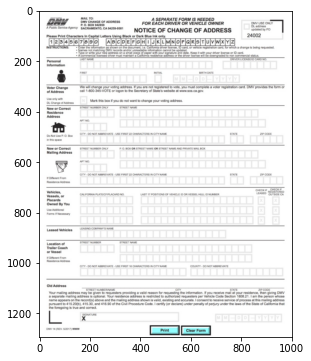

In [18]:
plt.imshow(imReference[:,:,::-1])
plt.show()

In [19]:
# Read image to be aligned
imFilename = DATA_PATH + "images/scanned-form.jpg"
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

Reading image to align :  ../data/images/scanned-form.jpg


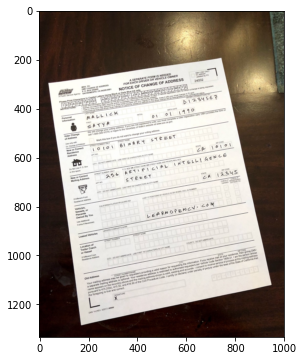

In [20]:
plt.imshow(im[:,:,::-1])
plt.show()

### Step 2: Detect Features

We then detect ORB features in the two images. Although we need only 4 features to compute the homography, typically hundreds of features are detected in the two images. We control the number of features using the parameter `MAX_FEATURES` in the Python code.

In [21]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

In [22]:
# Convert images to grayscale
im1Gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im2Gray = cv2.cvtColor(imReference, cv2.COLOR_BGR2GRAY)

In [23]:
# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

### Step 3: Match Features

We find the matching features in the two images, sort them by goodness of match and keep only a small percentage of original matches. We finally display the good matches on the images and write the file to disk for visual inspection. We use the [hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) as a measure of similarity between two feature descriptors. The matched features are shown in the figure below by drawing a line connecting them. Notice, we have many incorrect matches and thefore we will need to use a robust method to calculate homography in the next step.

In [24]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

# Draw top matches
imMatches = cv2.drawMatches(im, keypoints1, imReference, keypoints2, matches, None)
cv2.imwrite("matches.jpg", imMatches)

True

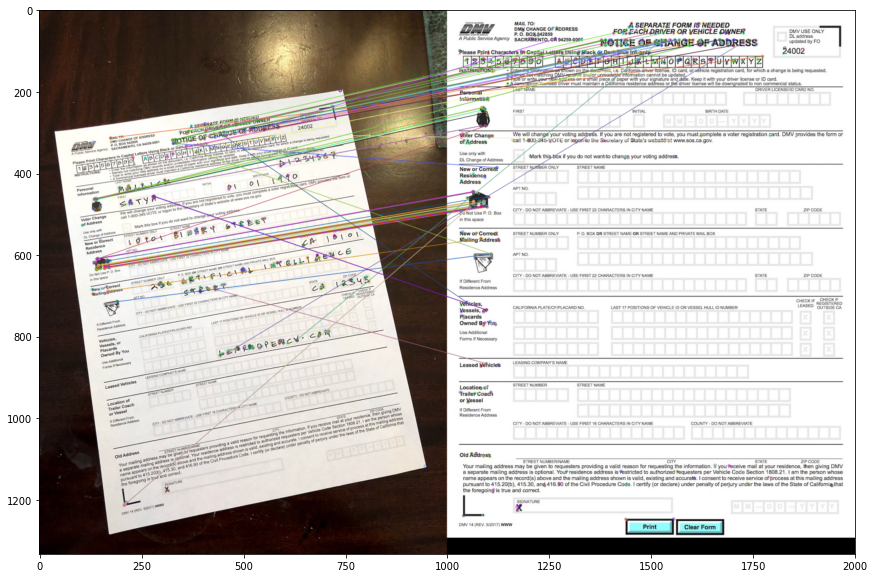

In [25]:
plt.figure(figsize=[20,10])
plt.imshow(imMatches[:,:,::-1])
plt.show()

Figure 4. Matching keypoints are shown by drawing a line between them. Click to enlarge image. The matches are not perfect and therefore we need a robust method for calculating the homography in the next step.</center> |

### Step 4: Calculate Homography

A homography can be computed when we have 4 or more corresponding points in two images. Automatic feature matching explained in the previous section does not always produce 100% accurate matches. It is not uncommon for 20-30% of the matches to be incorrect. Fortunately, the `findHomography` method utilizes a robust estimation technique called Random Sample Consensus (RANSAC) which produces the right result even in the presence of large number of bad matches.

In [16]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

### Step 5: Warping Image

Once an accurate homography has been calculated, the transformation can be applied to all pixels in one image to map it to the other image. This is done using the `warpPerspective` function in OpenCV. 

In [18]:
# Use homography
height, width, channels = imReference.shape
im1Reg = cv2.warpPerspective(im, h, (width, height))

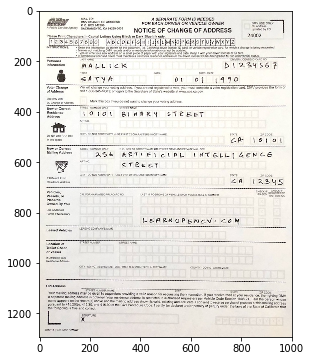

In [19]:
plt.imshow(im1Reg[:,:,::-1])
plt.show()

In [20]:
# Print estimated homography
print("Estimated homography : \n",  h)

Estimated homography : 
 [[ 1.39715559e+00 -2.00738930e-01 -8.91422787e+00]
 [ 2.22558069e-01  1.51190746e+00 -4.79064534e+02]
 [-6.28846541e-05  1.17130350e-04  1.00000000e+00]]
